# Michaelis-Menten kinetics dynamics

### The Michaelis-Menten kinetics is given by the following system of (coupled) ordinary differential equations (ODEs):

$$
\dot{x}^{(\nu)}_i = -x^{(\nu)}_i + \sum_j w_{i,j} \cdot \frac{x^{(\nu)}_j}{1 + x^{(\nu)}_j}, \quad i, j \in \{1, \dots, N\}
$$

# TODOs
- Add a 'B' coefficient to the sum term (i.e. $-Bx^{(\nu)}_i + \sum_j w_{i,j} \cdot \frac{x^{(\nu)}_j}{1 + x^{(\nu)}_j}, \quad i, j \in \{1, \dots, N\}$)
- "Colonial expansion" - Make the defects uneven (e.g. base_model W $->$ 10 Ws with p = 0.2 and 40 Ws with p = 0.8)
- "Colonial expansion" should decrease GCL (higher p $->$ lower GCL)

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import random

$$
\dot{x}^{(\nu)}_i = -Bx^{(\nu)}_i + \sum_j w_{i,j} \cdot \frac{x^{(\nu)}_j}{1 + x^{(\nu)}_j}, \quad i, j \in \{1, \dots, N\}
$$

In [232]:
# Set up the system of ODEs
def ode_system(t, x, W, B):
    N = len(x)  # Get the number of elements in the state vector
    derivative_vector = np.zeros(N)  # Initialize the derivative vector (set zeros as default)
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element according to the formula given in the paper
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N) if j != i)  # list comprehension
        derivative_vector[i] = -B*x[i] + sum_term
    return derivative_vector

N represents # of genes in each cell  
num_of_cells (M) represents # of cells as well as # of defects matrices (defects of weight matrix w)
p represents the probability of the base weight matrix to defect (non-zero elements probability to change)  
A cohort is a group of cells with similar properties (in our case identical p value and the same base_model weight matrix)  
A cell is a network of genes  
A gene is a node in the network with its connection's represented by the relevant weight matrix W  
We have <num_of_cohorts> cohorts, in each cohort we have <num_of_cells> (previously called M) cells, all cells in this cohort have evolved according to their corresponding weight matrix

In [237]:
# Initialize parameters
N = 50  # Number of genes in a cell
num_of_cells = 10#100  # (M) Number of cells in each cohort = # of defects matrices
avg_deg = 3 # Average # of non-zero elements in the matrix W

decide = lambda x: random.random() < x
q = 1  # Affects the range of the random numbers generated
probability_spacing = 0.25  #0.05
num_of_cohorts = int(1 / probability_spacing) + 1
p = np.linspace(0, 1, num_of_cohorts)  # probability to create a defect
W = [[np.zeros((N, N)) for _ in range(num_of_cells)] for ___ in range(
    num_of_cohorts)]  # Initialize the weight matrix with zeros. W[cohort index][defect index / cell index][(row, column)] Perhaps there is a simpler more elegant way to do this with smaller dimension arrays.

# I.C is an array where each element represents a cohort with different p and each cohort has an array of cells and each cell has a vector of initial conditions for each gene in the cell. initial_conditions[cohort index][defect index / cell index][gene index]
initial_conditions = [[np.random.rand(N) for _ in range(num_of_cells)] for __ in range(num_of_cohorts)]

num_of_time_stamps = 1000
t_final = 20
t = np.linspace(0, t_final, num_of_time_stamps)

In [238]:
for cohort_index in range(num_of_cohorts):
    # For each cohort (group of <num_of_cells> cells), create a system of <num_of_cells> w defect matrices

    # Set the base weight matrix for the current cohort
    # TODO: this is weird since I defined avg_deg as the average degree but I use it as a probability distribution (actual average might be different) maybe change that in the future
    # TODO: try to make the base model the same for all cohorts later
    base_model = np.array([[np.random.uniform(0, 2 * q) if (gene_i != gene_j and decide(avg_deg / (N - 1))) else 0
                            for gene_j in range(N)] for gene_i in range(N)])

    # TODO: the first iteration is useless since p[0] = 0 by definition and its a simple copy of base_model. Maybe change that in the future
    # Create defects of the weight matrix
    # TODO: Too many indentations, maybe refactor this code
    for defect_index in range(num_of_cells):
        for gene_i in range(N):
            for gene_j in range(N):
                if base_model[gene_i, gene_j] != 0:
                    if decide(p[cohort_index]):
                        # What if, by chance np.random.uniform(0, 2 * q) is the same as base_model[gene_i, gene_j] or if it is 0? these are edge cases that are rare and therefore not handled
                        W[cohort_index][defect_index][gene_i, gene_j] = np.random.uniform(0, 2 * q)
                    else:
                        W[cohort_index][defect_index][gene_i, gene_j] = base_model[gene_i, gene_j]
                else:
                    W[cohort_index][defect_index][gene_i, gene_j] = 0

..........................

In [239]:
print(len(W)) # num_of_cohorts. W is an array that each element represents a cohort with different p
print(len(W[num_of_cohorts - 1])) # num_of_cells. An element in W is an array of 50 weight matrices (each corresponds to a cell)
print(len(W[num_of_cohorts - 1][num_of_cells - 1])) # N (num of genes in each cell). Each weight matrix is an NxN matrix
print(W[num_of_cohorts - 1][num_of_cells - 1][(N-1, N-1)]) # A connection between the last gene with itself in the last cell in the last cohort (should be 0)

5
10
50
0.0


..........................

In [240]:
results = [[np.zeros((num_of_time_stamps, N)) for _ in range(num_of_cells)] for __ in range(num_of_cohorts)] # Initialize the results array
# results[cohort index][defect index][(row, column)] - rows represents timestamps, columns represent gene index

# Solve the ODEs for each cell in each cohort (num_of_cells X num_of_cohorts systems of ODE's (each system has N (num_of_genes) ode's)) and the corresponding initial conditions for the cells
for cohort_index in range(num_of_cohorts):
    for defect_index in range(num_of_cells):
        B = 1
        results[cohort_index][defect_index] = solve_ivp(ode_system, [t[0], t[-1]], initial_conditions[cohort_index][defect_index], args=(W[cohort_index][defect_index], B), t_eval=t)["y"].T # Transpose the solution so that rows = timestamps and columns = gene index

In [241]:
steady_state = np.zeros((num_of_cohorts, N, num_of_cells))
# steady_state[cohort index, gene index, cell index]

for cohort_j in range(num_of_cohorts):
    for cell_index in range(num_of_cells):
        steady_state[cohort_j, :, cell_index] = results[cohort_j][cell_index][-1]  # Get the last row (final time) of the cell (the steady state)

In [242]:
# Change 5 random genes in each cell in each cohort to 0
num_of_zero_genes = 5
for cohort_index in range(num_of_cohorts):
    for cell_index in range(num_of_cells):
        for _ in range(num_of_zero_genes):
            gene_index = random.randint(0, N - 1)
            steady_state[cohort_index, gene_index, cell_index] = 0

### Calculate Negative Spearman Correlation

In [243]:
negative_spearman_steady_state = [(1 - (spearmanr(steady_state[i])[0])) for i in range(num_of_cohorts)]
# spearman_steady_state[cohort index, cell_i, cell_j]

In [244]:
# get the off diagonal elements and graph a distribution of them:
off_diagonal_elements = [[] for _ in range(num_of_cohorts)]
# off_diagonal_elements[cohort index][off-diagonal element index]. The off-diagonal element index doesn't really have a meaning it is just a way to store these off-diagonal elements.

for cohort_index in range(num_of_cohorts):
    for cell_i in range(num_of_cells):
        for cell_j in range(num_of_cells):
            if cell_j > cell_i:
                off_diagonal_elements[cohort_index].append(negative_spearman_steady_state[cohort_index][cell_i][cell_j])

# Round to 2 decimal places to make the graph look normal
off_diagonal_elements = [np.round(element, decimals=2) for element in off_diagonal_elements]

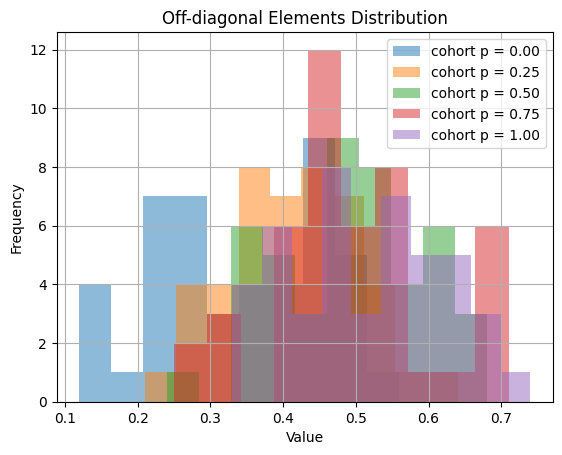

In [245]:
# Plot the off-diagonal elements distribution
for cohort_index in range(num_of_cohorts):
    plt.hist(off_diagonal_elements[cohort_index], alpha=0.5, label='cohort p = {:.2f}'.format(p[cohort_index]))

# Add title and labels
plt.title('Off-diagonal Elements Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [255]:
# Use dimensionality reduction to reduce the spearman matrix by using PCA

# Prepare the data
# negative_spearman_steady_state is a list of Negative Spearman correlation matrices (matrix for each cohort)
# Flatten the Spearman correlation matrices for PCA (e.g. [[1,2], [3,4]] --> [[1, 2, 3, 4]])
flattened_spearman = [matrix.flatten() for matrix in negative_spearman_steady_state]

# Scale the data - this will take care of the normalization step I mentioned above 
scaler = StandardScaler()
standardized_data = scaler.fit_transform(flattened_spearman)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(standardized_data)

# [variance of PC1, variance of PC2]
print("Variance ratio:", pca.explained_variance_ratio_)

# Print the PCA result [PC1, PC2]
print("PCA result:\n", pca_result)

Variance ratio: [0.44706067 0.24230354]
PCA result:
 [[-10.18920813   1.07244814]
 [ -4.41299916  -3.41451473]
 [  5.94158383   3.74120697]
 [  2.73701951   5.674287  ]
 [  5.92360395  -7.07342738]]


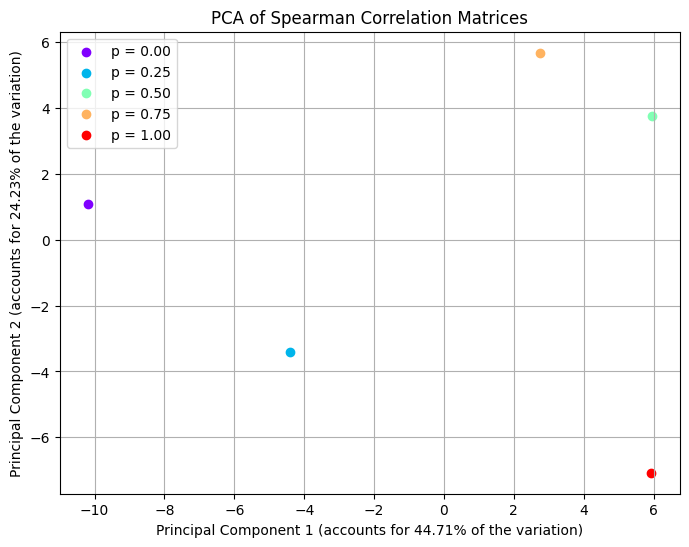

In [256]:
# Plot the PCA results with different colors for each point
plt.figure(figsize=(8, 6))
colors = cm.rainbow(np.linspace(0, 1, len(p)))
for i in range(num_of_cohorts):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[i], label=f'p = {p[i]:.2f}')

plt.title('PCA of Spearman Correlation Matrices')
plt.xlabel(
    'Principal Component 1 (accounts for {:.2f}% of the variation)'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel(
    'Principal Component 2 (accounts for {:.2f}% of the variation)'.format(pca.explained_variance_ratio_[1] * 100))
plt.legend()
plt.grid(True)
plt.show()

#### PCA
check out this video: https://youtu.be/FgakZw6K1QQ

##### PC1
- Calculate the average measurement for gene 1, 2, 3, ..., N - get the "center" of the data
- Recalculate the data relative to center (the center is the origin).
- Find the best fit linear line that passes through the origin for the data by choosing the line that maximizes the sum of the distances of the points projected by each one of the points on to the line - this line is PC1.
- Normalize the line to unit length it is the eigen vector (also called singular vector) of PC1. the proportion of each gene are called "loading scores" (kind of like tan(theta) = y/x in 2d). The average of the sum of squared distances (of the points projected on to the PC1 line) is the eigen value for PC1. The square root of the sum of the squared distances is called the singular value for PC1

##### PC2
- The line that is perpendicular to PC1 (m_pc1 * m_pc2 = -1 for 2d, the number of PC's will be the MIN(variables (genes), samples(cells))) This line is the eigen vector for PC2. The loading scores are the projection of the normalized line on to the gene1 axis (x) and the projection of the normalized line on to the gene2 axis (y). The average of the sum of squared distances (of the points projected on to the PC2 line) is the eigen value for PC2.

PC1 accounts for eigen_value_pc1/(eigen_value_pc1 + eigen_value_pc2) of the total variation
PC2 accounts for eigen_value_pc2 / (eigen_value_pc1 + eigen_value_pc2) of the total variation

We may have many PCi's, but after we calculated the principal components we simply project them to the 2 most dominant pc's (the ones with the highest eigen value i.e. highest variation) NOTE: this will only be good if they account for most of the variation.
Use a scree plot for the PCi's

In [ ]:
# from gcl_library import gcl
# 
# print(np.shape(actual_steady_state[0]))
# aaa = gcl(actual_steady_state[0], 200)
# aaa
# print(aaa)

In [ ]:
# Exercise from a site I found - irrelevant delete it later
# import pandas as pd
# 
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# 
# # load dataset into Pandas DataFrame
# df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [ ]:
# Delete this later but keep the steady state initialization
# results[cohort_index][defect_index][final_time=-1, :]
results[0][
    0]  #first cohort(p=0), first set of M(=50) w's - it is a vector where rows = time and columns = values; I want the last row:
steady_state_test = results[0][0][-1]
steady_state_test
steady_state = np.zeros((num_of_cohorts, N))

# for cohort_i in range(num_of_cohorts):
#     for defects_group_i in range(M):
#         steady_state[]
steady_state
# steady_state = [results[cohort_i][:][-1] for cohort_i in range(num_of_cohorts)] for gene in range(N)

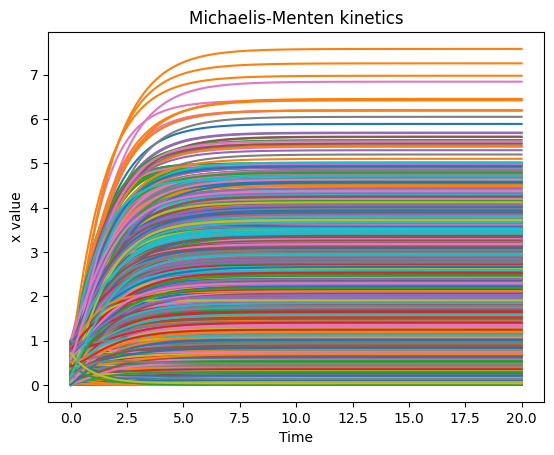

In [257]:
# Plot the results
for cohort_index in range(num_of_cohorts):
    for defect_index in range(num_of_cells):
        for gene in range(N):
            plt.plot(t, results[cohort_index][defect_index][:, gene])
plt.xlabel('Time')
plt.ylabel('x value')
plt.title('Michaelis-Menten kinetics')
plt.show()

# ---------

In [ ]:
# # initial state
# results[0][0, :]

In [ ]:
# final_state = [np.random.rand(N) for _ in range(N)]
# # final state
# for m in range(M):
#     final_state[m] = results[m][-1, :]

In [ ]:
# # Calculate the variance of the final state
# final_state_variance = np.var(final_state)
# print(final_state_variance)

In [ ]:
# W2_variance = np.var(W_strong_influence)
# print(W_strong_influence)

In [ ]:
# Save the final state vector to a csv file
# np.savetxt('final_state.csv', final_state, delimiter=',')